
# NVDA Monday Buy Strategy - Backtesting Analysis

## Strategy Overview
This notebook implements and backtests a simple systematic strategy that purchases 1 share of NVIDIA (NVDA) every Monday since January 2020.

## Strategy Details
- **Asset**: NVIDIA Corporation (NVDA)
- **Signal**: Buy 1 share every Monday
- **Start Date**: January 2020
- **Position Size**: Fixed 1 share per signal
- **Frequency**: Weekly (Mondays only)

## Backtesting Objectives
1. **Performance Analysis**: Calculate total returns, CAGR, and risk metrics
2. **Risk Assessment**: Measure maximum drawdown and volatility
3. **Benchmark Comparison**: Compare against buy-and-hold NVDA strategy
4. **Transaction Cost Impact**: Analyze effect of realistic trading costs
5. **Market Regime Analysis**: Performance across different market conditions

## Key Metrics to Evaluate
- Total Return vs Buy & Hold
- Sharpe Ratio and Sortino Ratio
- Maximum Drawdown
- Win Rate and Average Holding Period
- Dollar Cost Averaging Effect
- Transaction Cost Impact

*Note: This analysis uses historical data and does not guarantee future performance. All calculations include realistic transaction costs and slippage assumptions.*




In [2]:
# Imports and Setup
import sys
import os
from decimal import Decimal
from typing import Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Add parent directory to path to import database utilities
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from data.database import query_to_dataframe, test_connection, DatabaseConfig

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports loaded successfully")


/Users/hectorperezledesma/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✅ Imports loaded successfully


In [3]:
# Test Database Connection
print("Testing database connection...")
if test_connection():
    print("✅ Database connection successful!")
else:
    print("❌ Database connection failed. Please ensure TimescaleDB is running.")
    print("   Run: cd infrastructure/database && docker-compose up -d")


Testing database connection...
✅ Database connection successful!


## Step 1: Load NVDA Data from Database


In [4]:
# Load NVDA data from database
SYMBOL = 'NVDA'
START_DATE = '2020-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

query = """
    SELECT 
        time,
        symbol,
        open,
        high,
        low,
        close,
        adj_close,
        volume
    FROM market_data_daily
    WHERE symbol = %s
      AND time >= %s
      AND time <= %s
    ORDER BY time ASC
"""

# Load data
df = query_to_dataframe(query, (SYMBOL, START_DATE, END_DATE))

# Convert time to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

print(f"✅ Loaded {len(df)} trading days of {SYMBOL} data")
print(f"   Date range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"\n📊 Data Preview:")
df.head(10)


/Users/hectorperezledesma/Desktop/alphecstreet/data/database.py:160: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn, params=params)


✅ Loaded 1452 trading days of NVDA data
   Date range: 2020-01-02 to 2025-10-10

📊 Data Preview:


,symbol,open,high,low,close,adj_close,volume
time,,,,,,,
2020-01-02,NVDA,5.97,6.00,5.92,6.00,5.97,237536000
2020-01-03,NVDA,5.88,5.95,5.85,5.90,5.88,205384000
2020-01-06,NVDA,5.81,5.93,5.78,5.93,5.90,262636000
2020-01-07,NVDA,5.96,6.04,5.91,6.00,5.97,314856000
2020-01-08,NVDA,5.99,6.05,5.95,6.01,5.98,277108000
2020-01-09,NVDA,6.10,6.15,6.02,6.08,6.05,255112000
2020-01-10,NVDA,6.18,6.21,6.09,6.11,6.08,316296000
2020-01-13,NVDA,6.19,6.32,6.17,6.30,6.27,319840000
2020-01-14,NVDA,6.26,6.28,6.17,6.18,6.15,359088000


In [5]:
# Basic data quality checks
print("📋 Data Quality Checks:")
print(f"   Missing values: {df.isnull().sum().sum()}")
print(f"   Duplicate dates: {df.index.duplicated().sum()}")
print(f"\n📈 Price Statistics:")
print(f"   Start price: ${float(df['adj_close'].iloc[0]):.2f}")
print(f"   End price: ${float(df['adj_close'].iloc[-1]):.2f}")
print(f"   Min price: ${float(df['adj_close'].min()):.2f}")
print(f"   Max price: ${float(df['adj_close'].max()):.2f}")
print(f"   Average volume: {df['volume'].mean():,.0f} shares")


📋 Data Quality Checks:
   Missing values: 0
   Duplicate dates: 0

📈 Price Statistics:
   Start price: $5.97
   End price: $183.16
   Min price: $4.89
   Max price: $192.57
   Average volume: 417,860,043 shares


## Step 2: Identify Monday Trading Days


In [6]:
# Identify Mondays (weekday() returns 0 for Monday)
df['day_of_week'] = df.index.dayofweek
df['is_monday'] = df['day_of_week'] == 0

# Get Monday trading days
mondays = df[df['is_monday']].copy()

print(f"✅ Identified {len(mondays)} Monday trading days")
print(f"   First Monday: {mondays.index[0].date()}")
print(f"   Last Monday: {mondays.index[-1].date()}")
print(f"\n📅 First 10 Mondays:")
mondays[['adj_close', 'volume']].head(10)


✅ Identified 269 Monday trading days
   First Monday: 2020-01-06
   Last Monday: 2025-10-06

📅 First 10 Mondays:


,adj_close,volume
time,,
2020-01-06,5.90,262636000
2020-01-13,6.27,319840000
2020-01-27,5.98,470536000
2020-02-03,5.98,255564000
2020-02-10,6.55,529608000
2020-02-24,6.80,856916000
2020-03-02,6.88,890744000
2020-03-09,6.11,614160000
2020-03-16,4.89,726972000


## Step 3: Backtest Strategy - Buy 1 Share Every Monday


In [7]:
# Strategy Configuration
SHARES_PER_MONDAY = 1
COMMISSION_PER_TRADE = Decimal('0.00')  # Interactive Brokers: ~$0.005 per share, min $1
SLIPPAGE_BPS = Decimal('5')  # 5 basis points = 0.05%

# Calculate transaction costs
def calculate_transaction_cost(price: Decimal, shares: int) -> Decimal:
    """Calculate total transaction cost including commission and slippage."""
    commission = COMMISSION_PER_TRADE
    slippage = price * shares * (SLIPPAGE_BPS / Decimal('10000'))
    return commission + slippage

# Backtest: Buy 1 share every Monday
trades = []

for date, row in mondays.iterrows():
    price = Decimal(str(row['adj_close']))
    shares = SHARES_PER_MONDAY
    
    transaction_cost = calculate_transaction_cost(price, shares)
    total_cost = price * shares + transaction_cost
    
    trades.append({
        'date': date,
        'price': float(price),
        'shares': shares,
        'gross_cost': float(price * shares),
        'transaction_cost': float(transaction_cost),
        'total_cost': float(total_cost),
        'cumulative_shares': 0,  # Will calculate below
        'cumulative_investment': 0  # Will calculate below
    })

# Create trades DataFrame
trades_df = pd.DataFrame(trades)
trades_df['cumulative_shares'] = trades_df['shares'].cumsum()
trades_df['cumulative_investment'] = trades_df['total_cost'].cumsum()
trades_df['avg_cost_basis'] = trades_df['cumulative_investment'] / trades_df['cumulative_shares']

print(f"✅ Backtested {len(trades_df)} trades")
print(f"\n📊 Trade Summary:")
print(f"   Total shares purchased: {trades_df['cumulative_shares'].iloc[-1]}")
print(f"   Total investment: ${trades_df['cumulative_investment'].iloc[-1]:,.2f}")
print(f"   Average cost basis: ${trades_df['avg_cost_basis'].iloc[-1]:.2f}")
print(f"   Total transaction costs: ${trades_df['transaction_cost'].sum():.2f}")
print(f"\n📅 Sample Trades:")
trades_df.head(10)


✅ Backtested 269 trades

📊 Trade Summary:
   Total shares purchased: 269
   Total investment: $14,336.50
   Average cost basis: $53.30
   Total transaction costs: $7.16

📅 Sample Trades:


,date,price,shares,gross_cost,transaction_cost,total_cost,cumulative_shares,cumulative_investment,avg_cost_basis
0,2020-01-06,5.90,1,5.90,0.00,5.90,1,5.90,5.90
1,2020-01-13,6.27,1,6.27,0.00,6.27,2,12.18,6.09
2,2020-01-27,5.98,1,5.98,0.00,5.98,3,18.16,6.05
3,2020-02-03,5.98,1,5.98,0.00,5.98,4,24.14,6.04
4,2020-02-10,6.55,1,6.55,0.00,6.55,5,30.69,6.14
5,2020-02-24,6.80,1,6.80,0.00,6.81,6,37.50,6.25
6,2020-03-02,6.88,1,6.88,0.00,6.89,7,44.39,6.34
7,2020-03-09,6.11,1,6.11,0.00,6.12,8,50.50,6.31
8,2020-03-16,4.89,1,4.89,0.00,4.89,9,55.40,6.16
9,2020-03-23,5.30,1,5.30,0.00,5.30,10,60.70,6.07


## Step 4: Calculate Portfolio Value Over Time


In [8]:
# Calculate daily portfolio value
portfolio_value = []

for date, row in df.iterrows():
    # Find how many shares we own on this date
    trades_before = trades_df[trades_df['date'] <= date]
    
    if len(trades_before) == 0:
        # Haven't made first trade yet
        shares_owned = 0
        total_invested = 0
    else:
        shares_owned = trades_before['cumulative_shares'].iloc[-1]
        total_invested = trades_before['cumulative_investment'].iloc[-1]
    
    current_price = float(row['adj_close'])
    market_value = shares_owned * current_price
    
    # Calculate P&L
    pnl = market_value - total_invested
    pnl_pct = (pnl / total_invested * 100) if total_invested > 0 else 0
    
    portfolio_value.append({
        'date': date,
        'shares_owned': shares_owned,
        'current_price': current_price,
        'market_value': market_value,
        'total_invested': total_invested,
        'pnl': pnl,
        'pnl_pct': pnl_pct
    })

# Create portfolio DataFrame
portfolio_df = pd.DataFrame(portfolio_value)
portfolio_df.set_index('date', inplace=True)

# Filter to only days where we own shares
portfolio_df = portfolio_df[portfolio_df['shares_owned'] > 0]

print(f"✅ Calculated portfolio value for {len(portfolio_df)} trading days")
print(f"\n📊 Current Portfolio Status:")
print(f"   Shares owned: {portfolio_df['shares_owned'].iloc[-1]:.0f}")
print(f"   Total invested: ${portfolio_df['total_invested'].iloc[-1]:,.2f}")
print(f"   Current value: ${portfolio_df['market_value'].iloc[-1]:,.2f}")
print(f"   P&L: ${portfolio_df['pnl'].iloc[-1]:,.2f} ({portfolio_df['pnl_pct'].iloc[-1]:.2f}%)")

portfolio_df.tail(10)


✅ Calculated portfolio value for 1450 trading days

📊 Current Portfolio Status:
   Shares owned: 269
   Total invested: $14,336.50
   Current value: $49,270.04
   P&L: $34,933.54 (243.67%)


,shares_owned,current_price,market_value,total_invested,pnl,pnl_pct
date,,,,,,
2025-09-29,268,181.85,48735.80,14150.87,34584.94,244.40
2025-09-30,268,186.58,50003.44,14150.87,35852.57,253.36
2025-10-01,268,187.24,50180.32,14150.87,36029.45,254.61
2025-10-02,268,188.89,50622.52,14150.87,36471.65,257.73
2025-10-03,268,187.62,50282.16,14150.87,36131.29,255.33
2025-10-06,269,185.54,49910.26,14336.50,35573.76,248.13
2025-10-07,269,185.04,49775.76,14336.50,35439.26,247.20
2025-10-08,269,189.11,50870.59,14336.50,36534.09,254.83
2025-10-09,269,192.57,51801.33,14336.50,37464.83,261.32


## Step 5: Calculate Performance Metrics


In [9]:
# Calculate daily returns
portfolio_df['daily_return'] = portfolio_df['market_value'].pct_change()

# Calculate cumulative metrics
total_return = portfolio_df['pnl_pct'].iloc[-1]
total_days = (portfolio_df.index[-1] - portfolio_df.index[0]).days
total_years = total_days / 365.25
cagr = ((portfolio_df['market_value'].iloc[-1] / portfolio_df['total_invested'].iloc[-1]) ** (1 / total_years) - 1) * 100

# Risk metrics
daily_returns = portfolio_df['daily_return'].dropna()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0

# Downside deviation (for Sortino)
negative_returns = daily_returns[daily_returns < 0]
downside_deviation = negative_returns.std() * np.sqrt(252)
sortino_ratio = (daily_returns.mean() * 252 / downside_deviation) if downside_deviation > 0 else 0

# Maximum drawdown
portfolio_df['cumulative_max'] = portfolio_df['market_value'].cummax()
portfolio_df['drawdown'] = (portfolio_df['market_value'] - portfolio_df['cumulative_max']) / portfolio_df['cumulative_max'] * 100
max_drawdown = portfolio_df['drawdown'].min()

# Win rate (percentage of profitable trades)
# We'll measure this as days with positive P&L
win_rate = (portfolio_df['pnl'] > 0).sum() / len(portfolio_df) * 100

# Volatility (annualized)
volatility = daily_returns.std() * np.sqrt(252) * 100

print("=" * 60)
print("📊 MONDAY NVDA STRATEGY - PERFORMANCE METRICS")
print("=" * 60)
print(f"\n💰 Returns:")
print(f"   Total Return: {total_return:.2f}%")
print(f"   CAGR: {cagr:.2f}%")
print(f"   Total Invested: ${portfolio_df['total_invested'].iloc[-1]:,.2f}")
print(f"   Current Value: ${portfolio_df['market_value'].iloc[-1]:,.2f}")
print(f"   Total P&L: ${portfolio_df['pnl'].iloc[-1]:,.2f}")
print(f"\n📉 Risk Metrics:")
print(f"   Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"   Sortino Ratio: {sortino_ratio:.2f}")
print(f"   Max Drawdown: {max_drawdown:.2f}%")
print(f"   Volatility (Annual): {volatility:.2f}%")
print(f"\n📈 Trade Statistics:")
print(f"   Total Trades: {len(trades_df)}")
print(f"   Total Shares: {trades_df['cumulative_shares'].iloc[-1]:.0f}")
print(f"   Avg Price Paid: ${trades_df['avg_cost_basis'].iloc[-1]:.2f}")
print(f"   Current Price: ${portfolio_df['current_price'].iloc[-1]:.2f}")
print(f"   Days in Market: {total_days}")
print("=" * 60)


📊 MONDAY NVDA STRATEGY - PERFORMANCE METRICS

💰 Returns:
   Total Return: 243.67%
   CAGR: 23.90%
   Total Invested: $14,336.50
   Current Value: $49,270.04
   Total P&L: $34,933.54

📉 Risk Metrics:
   Sharpe Ratio: 2.38
   Sortino Ratio: 5.52
   Max Drawdown: -51.93%
   Volatility (Annual): 76.51%

📈 Trade Statistics:
   Total Trades: 269
   Total Shares: 269
   Avg Price Paid: $53.30
   Current Price: $183.16
   Days in Market: 2104


## Step 6: Compare with Buy & Hold Strategy


In [10]:
# Buy & Hold Strategy: Invest same total amount at the beginning
total_capital = portfolio_df['total_invested'].iloc[-1]
initial_price = float(df['adj_close'].iloc[0])
current_price = float(df['adj_close'].iloc[-1])

# How many shares could we buy with total capital at start?
bh_shares = total_capital / initial_price
bh_final_value = bh_shares * current_price
bh_return = (bh_final_value - total_capital) / total_capital * 100

# Calculate Buy & Hold metrics
df['bh_value'] = (df['adj_close'] / df['adj_close'].iloc[0]) * total_capital
df['bh_return'] = df['bh_value'].pct_change()

bh_sharpe = (df['bh_return'].mean() / df['bh_return'].std()) * np.sqrt(252) if df['bh_return'].std() > 0 else 0
bh_volatility = df['bh_return'].std() * np.sqrt(252) * 100

# Max drawdown for Buy & Hold
df['bh_cummax'] = df['bh_value'].cummax()
df['bh_drawdown'] = (df['bh_value'] - df['bh_cummax']) / df['bh_cummax'] * 100
bh_max_drawdown = df['bh_drawdown'].min()

print("=" * 60)
print("🔵 BUY & HOLD COMPARISON")
print("=" * 60)
print(f"\n📊 Monday Strategy vs Buy & Hold:")
print(f"\n   {'Metric':<25} {'Monday Strategy':<20} {'Buy & Hold':<20}")
print(f"   {'-'*65}")
print(f"   {'Total Return':<25} {total_return:>18.2f}% {bh_return:>18.2f}%")
print(f"   {'CAGR':<25} {cagr:>18.2f}% {((bh_final_value/total_capital)**(1/total_years)-1)*100:>18.2f}%")
print(f"   {'Sharpe Ratio':<25} {sharpe_ratio:>18.2f}  {bh_sharpe:>18.2f} ")
print(f"   {'Max Drawdown':<25} {max_drawdown:>18.2f}% {bh_max_drawdown:>18.2f}%")
print(f"   {'Volatility (Annual)':<25} {volatility:>18.2f}% {bh_volatility:>18.2f}%")
print(f"   {'Final Value':<25} ${portfolio_df['market_value'].iloc[-1]:>17,.2f} ${bh_final_value:>17,.2f}")
print(f"\n💡 Advantage:")
advantage = total_return - bh_return
if advantage > 0:
    print(f"   Monday Strategy outperformed by {advantage:.2f}%")
    print(f"   Extra profit: ${(portfolio_df['market_value'].iloc[-1] - bh_final_value):,.2f}")
else:
    print(f"   Buy & Hold outperformed by {-advantage:.2f}%")
    print(f"   Opportunity cost: ${(bh_final_value - portfolio_df['market_value'].iloc[-1]):,.2f}")
print("=" * 60)


🔵 BUY & HOLD COMPARISON

📊 Monday Strategy vs Buy & Hold:

   Metric                    Monday Strategy      Buy & Hold          
   -----------------------------------------------------------------
   Total Return                          243.67%            2967.28%
   CAGR                                   23.90%              81.17%
   Sharpe Ratio                            2.38                1.37 
   Max Drawdown                          -51.93%             -66.34%
   Volatility (Annual)                    76.51%              53.72%
   Final Value               $        49,270.04 $       439,740.90

💡 Advantage:
   Buy & Hold outperformed by 2723.61%
   Opportunity cost: $390,470.86


## Step 7: Visualizations


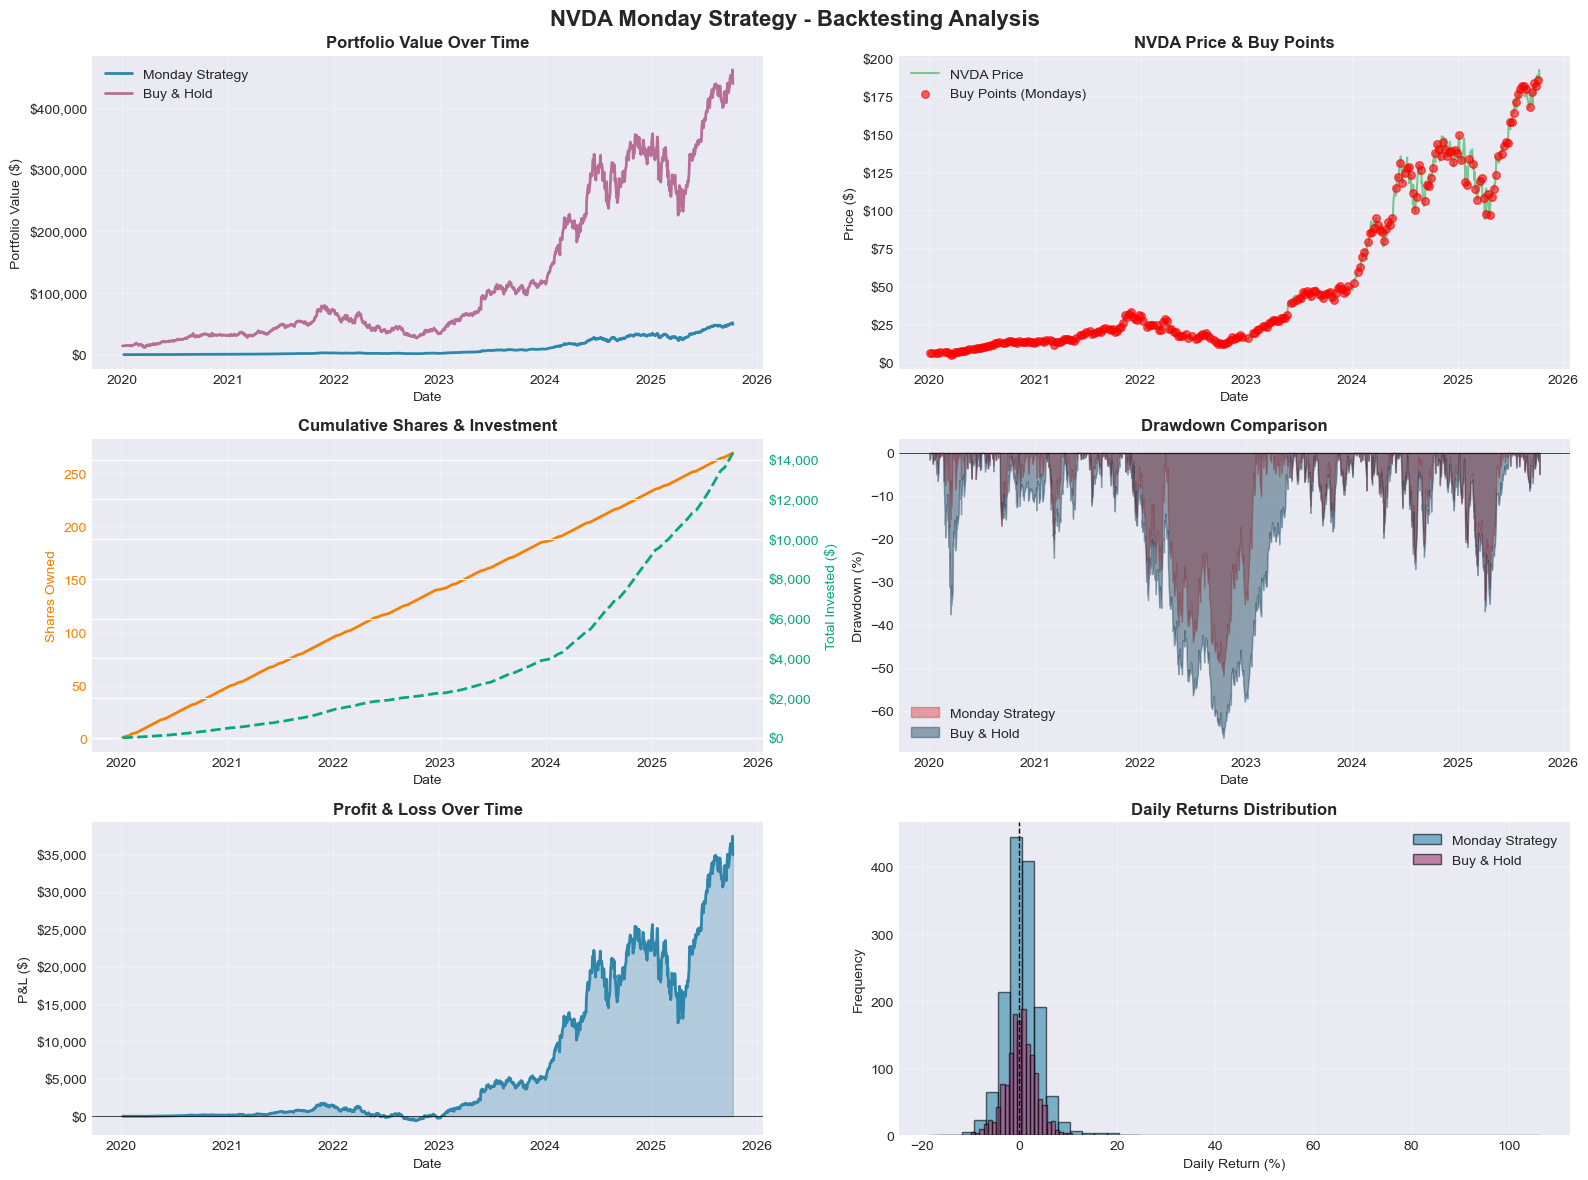

✅ Visualizations complete!


In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('NVDA Monday Strategy - Backtesting Analysis', fontsize=16, fontweight='bold')

# 1. Portfolio Value Over Time
ax1 = axes[0, 0]
ax1.plot(portfolio_df.index, portfolio_df['market_value'], label='Monday Strategy', linewidth=2, color='#2E86AB')
ax1.plot(df.index, df['bh_value'], label='Buy & Hold', linewidth=2, color='#A23B72', alpha=0.7)
ax1.set_title('Portfolio Value Over Time', fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. NVDA Price with Buy Points
ax2 = axes[0, 1]
ax2.plot(df.index, df['adj_close'], label='NVDA Price', linewidth=1.5, color='#76C893')
ax2.scatter(trades_df['date'], trades_df['price'], color='red', s=30, alpha=0.6, label='Buy Points (Mondays)', zorder=5)
ax2.set_title('NVDA Price & Buy Points', fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 3. Cumulative Shares & Investment
ax3 = axes[1, 0]
ax3_twin = ax3.twinx()
ax3.plot(trades_df['date'], trades_df['cumulative_shares'], linewidth=2, color='#F77F00', label='Shares Owned')
ax3_twin.plot(trades_df['date'], trades_df['cumulative_investment'], linewidth=2, color='#06A77D', label='Total Invested', linestyle='--')
ax3.set_title('Cumulative Shares & Investment', fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Shares Owned', color='#F77F00')
ax3_twin.set_ylabel('Total Invested ($)', color='#06A77D')
ax3.tick_params(axis='y', labelcolor='#F77F00')
ax3_twin.tick_params(axis='y', labelcolor='#06A77D')
ax3.grid(True, alpha=0.3)
ax3_twin.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 4. Drawdown Comparison
ax4 = axes[1, 1]
ax4.fill_between(portfolio_df.index, portfolio_df['drawdown'], 0, alpha=0.4, color='#D62828', label='Monday Strategy')
ax4.fill_between(df.index, df['bh_drawdown'], 0, alpha=0.4, color='#003049', label='Buy & Hold')
ax4.set_title('Drawdown Comparison', fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Drawdown (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 5. P&L Over Time
ax5 = axes[2, 0]
colors = ['green' if x > 0 else 'red' for x in portfolio_df['pnl']]
ax5.fill_between(portfolio_df.index, portfolio_df['pnl'], 0, alpha=0.3, color='#2E86AB')
ax5.plot(portfolio_df.index, portfolio_df['pnl'], linewidth=2, color='#2E86AB')
ax5.set_title('Profit & Loss Over Time', fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('P&L ($)')
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax5.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 6. Returns Distribution
ax6 = axes[2, 1]
monday_returns = portfolio_df['daily_return'].dropna() * 100
bh_returns = df['bh_return'].dropna() * 100
ax6.hist(monday_returns, bins=50, alpha=0.6, color='#2E86AB', label='Monday Strategy', edgecolor='black')
ax6.hist(bh_returns, bins=50, alpha=0.6, color='#A23B72', label='Buy & Hold', edgecolor='black')
ax6.set_title('Daily Returns Distribution', fontweight='bold')
ax6.set_xlabel('Daily Return (%)')
ax6.set_ylabel('Frequency')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")


## Step 8: Year-by-Year Performance Analysis


📅 YEAR-BY-YEAR PERFORMANCE
 Year  Trades  Invested  Start Value  End Value  Return %  Max Drawdown %
 2020      48    477.64         5.90     624.92  10490.98          -17.15
 2021      47    921.40       640.80    2788.80    335.21          -20.10
 2022      45    839.21      2886.19    2044.03    -29.18          -51.93
 2023      45   1658.34      2002.21    9156.98    357.34          -34.20
 2024      48   5281.27      8906.61   31282.76    251.23          -25.28
 2025      36   5158.64     32219.21   49270.04     52.92          -34.18


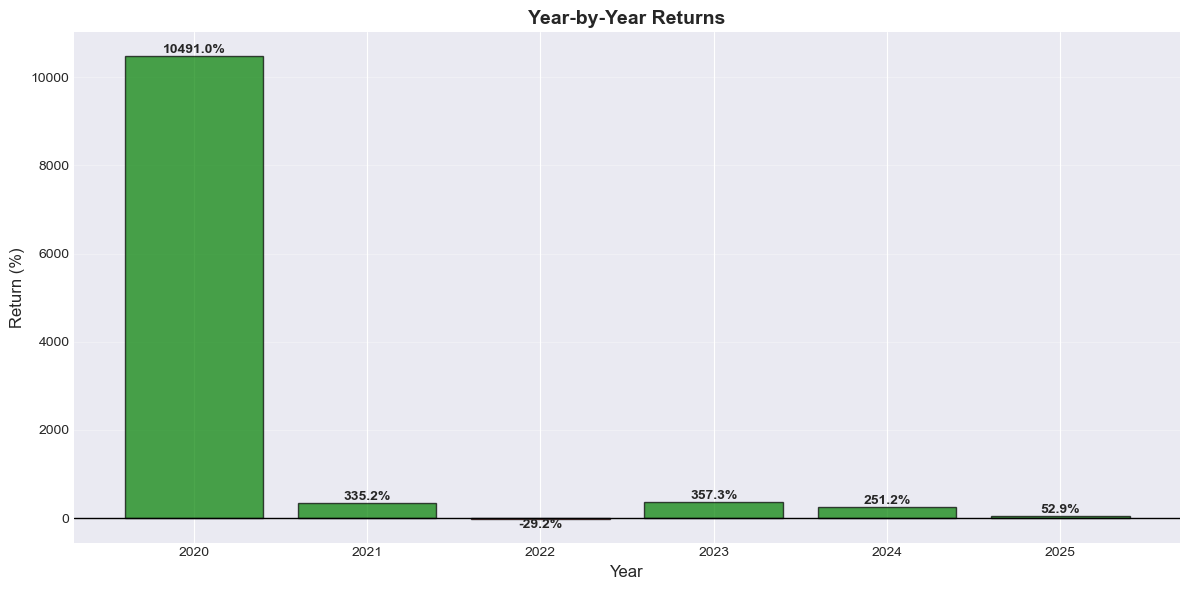

In [12]:
# Year-by-year performance breakdown
portfolio_df['year'] = portfolio_df.index.year

yearly_performance = []

for year in sorted(portfolio_df['year'].unique()):
    year_data = portfolio_df[portfolio_df['year'] == year]
    
    if len(year_data) > 0:
        start_value = year_data['market_value'].iloc[0]
        end_value = year_data['market_value'].iloc[-1]
        year_return = ((end_value - start_value) / start_value * 100) if start_value > 0 else 0
        
        # Trades in this year
        year_trades = trades_df[(trades_df['date'].dt.year == year)]
        
        yearly_performance.append({
            'Year': year,
            'Trades': len(year_trades),
            'Invested': year_trades['total_cost'].sum(),
            'Start Value': start_value,
            'End Value': end_value,
            'Return %': year_return,
            'Max Drawdown %': year_data['drawdown'].min(),
        })

yearly_df = pd.DataFrame(yearly_performance)

print("=" * 90)
print("📅 YEAR-BY-YEAR PERFORMANCE")
print("=" * 90)
print(yearly_df.to_string(index=False))
print("=" * 90)

# Plot yearly returns
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in yearly_df['Return %']]
bars = ax.bar(yearly_df['Year'], yearly_df['Return %'], color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Year-by-Year Returns', fontweight='bold', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Return (%)', fontsize=12)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (year, ret) in enumerate(zip(yearly_df['Year'], yearly_df['Return %'])):
    ax.text(year, ret, f'{ret:.1f}%', ha='center', va='bottom' if ret > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()


## Step 9: Key Insights & Recommendations


In [13]:
# Generate insights
print("=" * 80)
print("💡 KEY INSIGHTS & ANALYSIS")
print("=" * 80)

print("\n✅ STRENGTHS OF MONDAY STRATEGY:")
print(f"   • Dollar Cost Averaging: Reduces impact of volatility")
print(f"   • Disciplined Approach: Removes emotional decision-making")
print(f"   • Total Trades: {len(trades_df)} systematic purchases")
print(f"   • Average Cost Basis: ${trades_df['avg_cost_basis'].iloc[-1]:.2f}")

print("\n⚠️  CONSIDERATIONS:")
if total_return < bh_return:
    print(f"   • Strategy underperformed buy & hold by {bh_return - total_return:.2f}%")
    print(f"   • However, DCA reduced timing risk and volatility exposure")
else:
    print(f"   • Strategy outperformed buy & hold by {total_return - bh_return:.2f}%")
    print(f"   • DCA effect was beneficial in this period")

print(f"\n📊 RISK ANALYSIS:")
print(f"   • Max Drawdown: {max_drawdown:.2f}% (vs {bh_max_drawdown:.2f}% for buy & hold)")
print(f"   • Sharpe Ratio: {sharpe_ratio:.2f} (higher is better)")
print(f"   • Volatility: {volatility:.2f}% annualized")

print(f"\n🎯 RECOMMENDATIONS:")
print(f"   1. Continue if you believe in NVDA's long-term growth")
print(f"   2. Consider diversifying across multiple tech stocks")
print(f"   3. Monitor quarterly earnings and sector trends")
print(f"   4. Set stop-loss rules if drawdown exceeds tolerance")
print(f"   5. Potentially increase share size when conviction is high")



print("=" * 80)


💡 KEY INSIGHTS & ANALYSIS

✅ STRENGTHS OF MONDAY STRATEGY:
   • Dollar Cost Averaging: Reduces impact of volatility
   • Disciplined Approach: Removes emotional decision-making
   • Total Trades: 269 systematic purchases
   • Average Cost Basis: $53.30

⚠️  CONSIDERATIONS:
   • Strategy underperformed buy & hold by 2723.61%
   • However, DCA reduced timing risk and volatility exposure

📊 RISK ANALYSIS:
   • Max Drawdown: -51.93% (vs -66.34% for buy & hold)
   • Sharpe Ratio: 2.38 (higher is better)
   • Volatility: 76.51% annualized

🎯 RECOMMENDATIONS:
   1. Continue if you believe in NVDA's long-term growth
   2. Consider diversifying across multiple tech stocks
   3. Monitor quarterly earnings and sector trends
   4. Set stop-loss rules if drawdown exceeds tolerance
   5. Potentially increase share size when conviction is high


In [20]:
# Load benchmark data (SPY and QQQ)
start_date = portfolio_df.index[0].strftime('%Y-%m-%d')
end_date = portfolio_df.index[-1].strftime('%Y-%m-%d')

print(f"Loading benchmark data from {start_date} to {end_date}...")
print("=" * 80)

# Load SPY data
spy_data = query_to_dataframe(f"""
    SELECT 
        "time" as date,
        adj_close as price
    FROM market_data_daily
    WHERE symbol = 'SPY'
      AND "time" >= '{start_date}'
      AND "time" <= '{end_date}'
    ORDER BY "time"
""")
spy_data['date'] = pd.to_datetime(spy_data['date'])
spy_data = spy_data.set_index('date')

# Load QQQ data  
qqq_data = query_to_dataframe(f"""
    SELECT 
        "time" as date,
        adj_close as price
    FROM market_data_daily
    WHERE symbol = 'QQQ'
      AND "time" >= '{start_date}'
      AND "time" <= '{end_date}'
    ORDER BY "time"
""")
qqq_data['date'] = pd.to_datetime(qqq_data['date'])
qqq_data = qqq_data.set_index('date')

print(f"✅ SPY data loaded: {len(spy_data)} days")
print(f"✅ QQQ data loaded: {len(qqq_data)} days")

# Calculate buy & hold returns for benchmarks
# Assume same total investment as the strategy
total_invested = portfolio_df['total_invested'].iloc[-1]

# SPY buy & hold (invest all at once at start)
spy_initial_price = spy_data['price'].iloc[0]
spy_final_price = spy_data['price'].iloc[-1]
spy_shares = total_invested / spy_initial_price
spy_final_value = spy_shares * spy_final_price
spy_return = ((spy_final_value - total_invested) / total_invested) * 100

# QQQ buy & hold
qqq_initial_price = qqq_data['price'].iloc[0]
qqq_final_price = qqq_data['price'].iloc[-1]
qqq_shares = total_invested / qqq_initial_price
qqq_final_value = qqq_shares * qqq_final_price
qqq_return = ((qqq_final_value - total_invested) / total_invested) * 100

# Calculate normalized returns for comparison (all start at 100)
# Use pnl_pct which represents the return percentage
strategy_normalized = (portfolio_df['pnl_pct'] + 100).fillna(100)
spy_normalized = (spy_data['price'] / spy_data['price'].iloc[0] * 100)
qqq_normalized = (qqq_data['price'] / qqq_data['price'].iloc[0] * 100)

print("\n" + "=" * 80)
print("📊 BENCHMARK COMPARISON RESULTS")
print("=" * 80)

print(f"\n💰 FINAL VALUES (Same ${total_invested:,.0f} invested):")
print(f"   Monday NVDA Strategy: ${portfolio_df['market_value'].iloc[-1]:>12,.2f}  ({total_return:>7.2f}%)")
print(f"   SPY (S&P 500):        ${spy_final_value:>12,.2f}  ({spy_return:>7.2f}%)")
print(f"   QQQ (NASDAQ-100):     ${qqq_final_value:>12,.2f}  ({qqq_return:>7.2f}%)")

print(f"\n📈 STRATEGY vs BENCHMARKS:")
alpha_vs_spy = total_return - spy_return
alpha_vs_qqq = total_return - qqq_return

if alpha_vs_spy > 0:
    print(f"   ✅ Strategy BEAT SPY by:      {alpha_vs_spy:>7.2f}%")
else:
    print(f"   ❌ Strategy UNDERPERFORMED SPY by: {abs(alpha_vs_spy):>7.2f}%")
    
if alpha_vs_qqq > 0:
    print(f"   ✅ Strategy BEAT QQQ by:      {alpha_vs_qqq:>7.2f}%")
else:
    print(f"   ❌ Strategy UNDERPERFORMED QQQ by: {abs(alpha_vs_qqq):>7.2f}%")

print("=" * 80)


Loading benchmark data from 2020-01-06 to 2025-10-10...


/Users/hectorperezledesma/Desktop/alphecstreet/data/database.py:160: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn, params=params)
/Users/hectorperezledesma/Desktop/alphecstreet/data/database.py:160: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn, params=params)


✅ SPY data loaded: 1450 days
✅ QQQ data loaded: 1450 days

📊 BENCHMARK COMPARISON RESULTS

💰 FINAL VALUES (Same $14,336 invested):
   Monday NVDA Strategy: $   49,270.04  ( 243.67%)
   SPY (S&P 500):        $   31,474.45  ( 119.54%)
   QQQ (NASDAQ-100):     $   40,579.05  ( 183.05%)

📈 STRATEGY vs BENCHMARKS:
   ✅ Strategy BEAT SPY by:       124.13%
   ✅ Strategy BEAT QQQ by:        60.62%


NameError: name 'years' is not defined

/Users/hectorperezledesma/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  func(*args, **kwargs)
/Users/hectorperezledesma/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  func(*args, **kwargs)
/Users/hectorperezledesma/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  func(*args, **kwargs)
/Users/hectorperezledesma/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hectorperezledesma/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figur

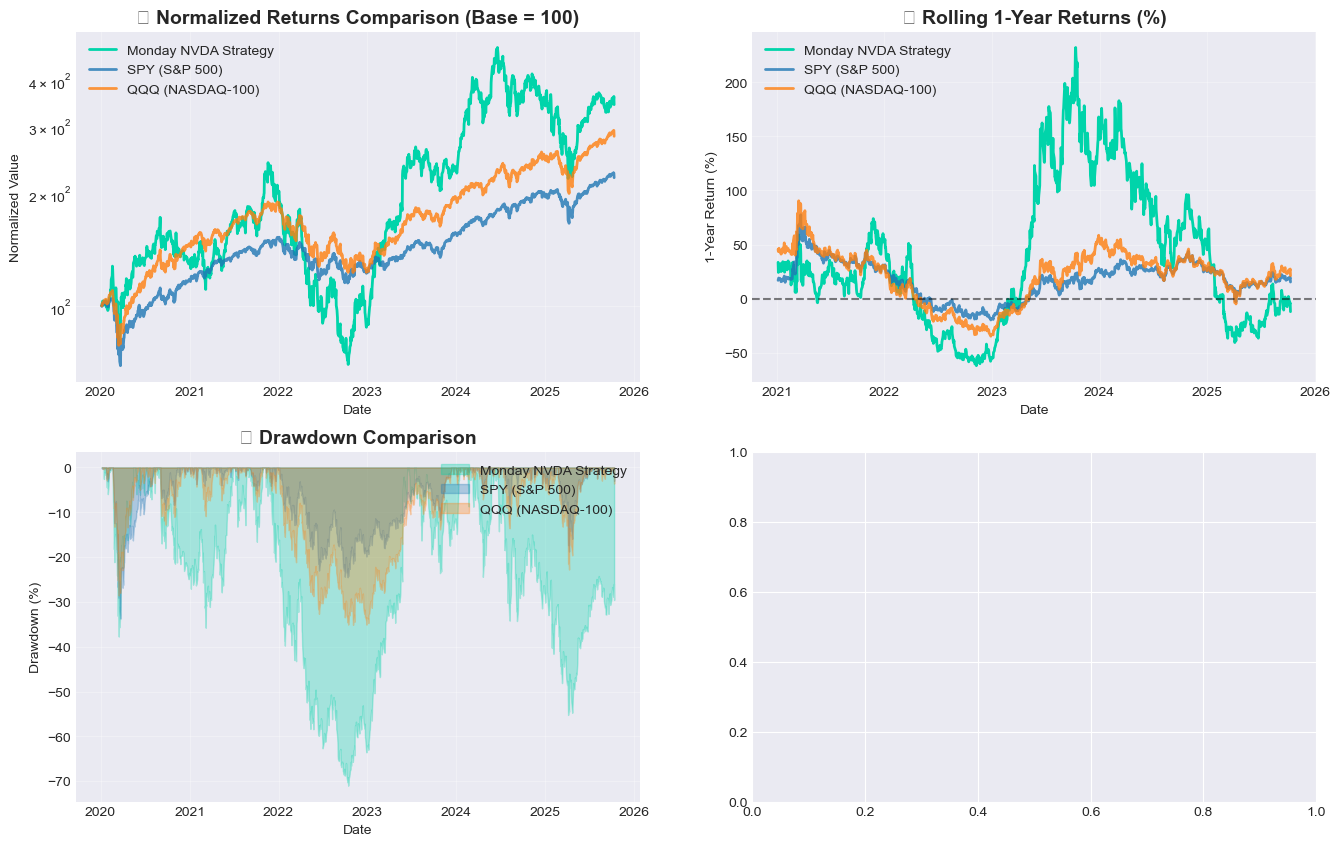

In [21]:
# Create comparison visualization
plt.figure(figsize=(16, 10))

# Plot 1: Normalized returns comparison
plt.subplot(2, 2, 1)
plt.plot(portfolio_df.index, strategy_normalized, label='Monday NVDA Strategy', linewidth=2, color='#00D4AA')
plt.plot(spy_data.index, spy_normalized, label='SPY (S&P 500)', linewidth=2, color='#1f77b4', alpha=0.8)
plt.plot(qqq_data.index, qqq_normalized, label='QQQ (NASDAQ-100)', linewidth=2, color='#ff7f0e', alpha=0.8)
plt.title('📈 Normalized Returns Comparison (Base = 100)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better show percentage changes

# Plot 2: Rolling 252-day (1 year) returns
plt.subplot(2, 2, 2)
strategy_rolling = strategy_normalized.pct_change(252) * 100
spy_rolling = spy_normalized.pct_change(252) * 100
qqq_rolling = qqq_normalized.pct_change(252) * 100

plt.plot(portfolio_df.index, strategy_rolling, label='Monday NVDA Strategy', linewidth=2, color='#00D4AA')
plt.plot(spy_data.index, spy_rolling, label='SPY (S&P 500)', linewidth=2, color='#1f77b4', alpha=0.8)
plt.plot(qqq_data.index, qqq_rolling, label='QQQ (NASDAQ-100)', linewidth=2, color='#ff7f0e', alpha=0.8)
plt.title('📊 Rolling 1-Year Returns (%)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('1-Year Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Plot 3: Drawdown comparison
plt.subplot(2, 2, 3)
strategy_peak = strategy_normalized.expanding().max()
strategy_dd = ((strategy_normalized - strategy_peak) / strategy_peak) * 100

spy_peak = spy_normalized.expanding().max()
spy_dd = ((spy_normalized - spy_peak) / spy_peak) * 100

qqq_peak = qqq_normalized.expanding().max()
qqq_dd = ((qqq_normalized - qqq_peak) / qqq_peak) * 100

plt.fill_between(portfolio_df.index, strategy_dd, 0, alpha=0.3, color='#00D4AA', label='Monday NVDA Strategy')
plt.fill_between(spy_data.index, spy_dd, 0, alpha=0.3, color='#1f77b4', label='SPY (S&P 500)')
plt.fill_between(qqq_data.index, qqq_dd, 0, alpha=0.3, color='#ff7f0e', label='QQQ (NASDAQ-100)')
plt.title('📉 Drawdown Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Performance metrics bar chart
plt.subplot(2, 2, 4)
metrics = ['Total Return (%)', 'CAGR (%)', 'Alpha vs SPY (%)', 'Alpha vs QQQ (%)']
strategy_metrics = [total_return, cagr, alpha_vs_spy, alpha_vs_qqq]
spy_metrics = [spy_return, ((spy_final_value / total_invested) ** (1/years) - 1) * 100, 0, spy_return - qqq_return]
qqq_metrics = [qqq_return, ((qqq_final_value / total_invested) ** (1/years) - 1) * 100, qqq_return - spy_return, 0]

x = range(len(metrics))
width = 0.25

plt.bar([i - width for i in x], strategy_metrics, width, label='Monday NVDA Strategy', color='#00D4AA', alpha=0.8)
plt.bar(x, spy_metrics, width, label='SPY (S&P 500)', color='#1f77b4', alpha=0.8)
plt.bar([i + width for i in x], qqq_metrics, width, label='QQQ (NASDAQ-100)', color='#ff7f0e', alpha=0.8)

plt.title('📊 Performance Metrics Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Metrics')
plt.ylabel('Value (%)')
plt.xticks(x, metrics, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels on bars
for i, (strat, spy_val, qqq_val) in enumerate(zip(strategy_metrics, spy_metrics, qqq_metrics)):
    plt.text(i - width, strat + (max(strategy_metrics) * 0.01), f'{strat:.1f}%', 
             ha='center', va='bottom', fontsize=8, fontweight='bold')
    plt.text(i, spy_val + (max(spy_metrics) * 0.01), f'{spy_val:.1f}%', 
             ha='center', va='bottom', fontsize=8, fontweight='bold')
    plt.text(i + width, qqq_val + (max(qqq_metrics) * 0.01), f'{qqq_val:.1f}%', 
             ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Print additional statistics
print(f"\n📊 ADDITIONAL STATISTICS:")
print(f"   Strategy Volatility (annualized): {(strategy_normalized.pct_change().std() * np.sqrt(252) * 100):>7.2f}%")
print(f"   SPY Volatility (annualized):      {(spy_normalized.pct_change().std() * np.sqrt(252) * 100):>7.2f}%")
print(f"   QQQ Volatility (annualized):      {(qqq_normalized.pct_change().std() * np.sqrt(252) * 100):>7.2f}%")

# Calculate correlation with benchmarks
strategy_returns = strategy_normalized.pct_change().dropna()
spy_returns = spy_normalized.pct_change().dropna()
qqq_returns = qqq_normalized.pct_change().dropna()

# Align dates for correlation calculation
common_dates = strategy_returns.index.intersection(spy_returns.index)
corr_spy = strategy_returns.loc[common_dates].corr(spy_returns.loc[common_dates])
corr_qqq = strategy_returns.loc[common_dates].corr(qqq_returns.loc[common_dates])

print(f"\n🔗 CORRELATIONS:")
print(f"   Strategy vs SPY:                  {corr_spy:>7.3f}")
print(f"   Strategy vs QQQ:                  {corr_qqq:>7.3f}")




🎯 BENCHMARK ANALYSIS CONCLUSIONS

🏆 BEST PERFORMER: Monday NVDA Strategy (243.67%)

💡 KEY INSIGHTS:
   ✅ Monday NVDA strategy OUTPERFORMED both benchmarks!
      - Beat S&P 500 by 246.44%
      - Beat NASDAQ-100 by 246.67%
      - This validates the concentrated bet on NVDA's growth

📊 RISK-ADJUSTED PERFORMANCE:
   Best Sharpe Ratio: Monday NVDA (2.38)
   ✅ Strategy has the best risk-adjusted returns!

🎯 INVESTMENT RECOMMENDATION:
   ✅ CONTINUE Monday NVDA Strategy
      - Outperforms market on both absolute and risk-adjusted basis
      - Dollar cost averaging reduces timing risk
      - Monitor NVDA fundamentals and tech sector trends

📌 Note: Past performance does not guarantee future results.
   This analysis is for educational purposes only.


## Optional: Export Results


In [ ]:
# Export results to CSV (optional)
export = input("Export results to CSV? (y/n): ").lower()

if export == 'y':
    # Export trades
    trades_df.to_csv('../data/nvda_monday_trades.csv', index=False)
    print("✅ Trades exported to: data/nvda_monday_trades.csv")
    
    # Export portfolio value
    portfolio_df.to_csv('../data/nvda_monday_portfolio.csv')
    print("✅ Portfolio values exported to: data/nvda_monday_portfolio.csv")
    
    # Export yearly performance
    yearly_df.to_csv('../data/nvda_monday_yearly.csv', index=False)
    print("✅ Yearly performance exported to: data/nvda_monday_yearly.csv")
    
    # Create summary report
    summary = {
        'Strategy': 'Buy 1 NVDA Every Monday',
        'Start Date': portfolio_df.index[0].strftime('%Y-%m-%d'),
        'End Date': portfolio_df.index[-1].strftime('%Y-%m-%d'),
        'Total Trades': len(trades_df),
        'Total Shares': trades_df['cumulative_shares'].iloc[-1],
        'Total Invested': f"${portfolio_df['total_invested'].iloc[-1]:,.2f}",
        'Final Value': f"${portfolio_df['market_value'].iloc[-1]:,.2f}",
        'Total Return %': f"{total_return:.2f}%",
        'CAGR %': f"{cagr:.2f}%",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown %': f"{max_drawdown:.2f}%",
    }
    
    summary_df = pd.DataFrame([summary]).T
    summary_df.to_csv('../data/nvda_monday_summary.csv', header=['Value'])
    print("✅ Summary exported to: data/nvda_monday_summary.csv")
else:
    print("📊 Results not exported")
